In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [56]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green",'dusty purple']
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,marker='.',
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location + model.transitions.r,
    z = np.argmax(xy.dot(model.transitions.Rs.T))
    pdb.set_trace()
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

In [2]:
##===== Read in Data =====##
data_df = pd.read_hdf('./data/preparatory_movement_data.h5')
nTrials = len(data_df)
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[309.085771040483, 309.085771040483, 308.87452...","[296.588482140354, 295.88196968918214, 295.557...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[573.0687866210938, 573.0687866210938, 573.068...","[512.955810546875, 513.0393676757812, 513.0393...","[322.8341997502523, 322.61465629322106, 322.61...","[268.1868448211816, 267.6647500946191, 267.522...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[321.2914378129316, 320.8449351273847, 320.844...","[299.88609963095644, 299.4508884493158, 298.10...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[572.3963012695312, 572.5952758789062, 572.698...","[522.5081787109375, 524.5397338867188, 525.219...","[322.1634885672048, 321.95636576447043, 321.90...","[312.353937981537, 311.36901366513075, 311.369...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[292.9151773163767, 292.6319741913767, 291.174...","[252.98197382146657, 252.98197382146657, 252.9...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[572.5652465820312, 572.5652465820312, 572.565...","[524.19970703125, 524.19970703125, 524.1997070...","[321.70764668782556, 321.66675313313806, 321.3...","[290.35496151086056, 290.35496151086056, 289.4...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[313.55253375600705, 313.2895332677258, 313.14...","[265.110596227482, 263.81851248724763, 263.649...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[573.1360473632812, 573.3661499023438, 573.473...","[1.9259750843048096, 265.081298828125, 528.512...","[323.10162814949797, 322.54117282723234, 322.3...","[333.40595751365845, 284.7679875429553, 284.76...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[313.9351677623222, 312.51375052599406, 310.65...","[244.44779596096134, 244.44779596096134, 244.4...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[572.7760009765625, 573.4033813476562, 573.407...","[522.1571655273438, 522.1571655273438, 522.157...","[320.158985665174, 319.99281745228336, 319.964...","[291.3589452728023, 291.3589452728023, 291.358...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [3]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    
    xy_list = []; ll_list = []
    for view in ['Side','Top']:
        for ptstr in ['Nose','LEye','LEar']:
            #Get coordinates of Take-Off platform
            xc = np.nanmean(data_df.loc[iTrial]['{} TakeFL x'.format(view)])
            yc = np.nanmean(data_df.loc[iTrial]['{} TakeFL y'.format(view)])

            x = data_df.loc[iTrial]['{} {} x'.format(view,ptstr)]
            y = data_df.loc[iTrial]['{} {} y'.format(view,ptstr)]
            llhood = data_df.loc[iTrial]['{} {} likelihood'.format(view,ptstr)]

            #Coordinates relative to take-off platform
            xy_list.append((x-xc,y-yc))

            #Create mask for points that have a confidence lower than the given threshold
            mask = llhood > confidence_threshold
            ll_list.append((mask,mask))
    
    data_list.append(np.vstack(xy_list).T)
    mask_list.append(np.vstack(ll_list).T)


In [4]:
data_list[0].shape

(209, 12)

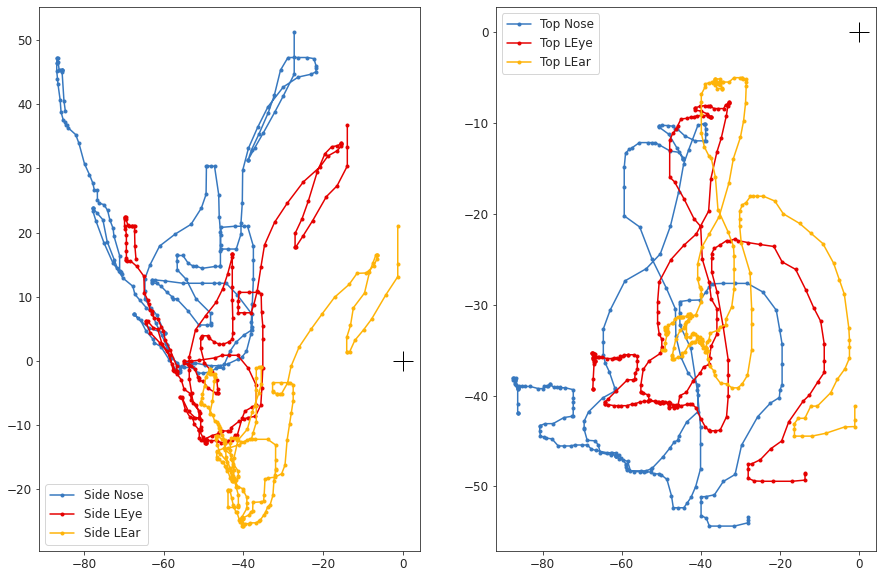

In [5]:
iTrial = 98
data = data_list[iTrial]

fig, axes = plt.subplots(1,2,figsize=(15,10))

#Plot traces
for ii,view in enumerate(['Side','Top']):
    ax = axes[ii]
    for jj,ptstr in enumerate(['Nose','LEye','LEar']):
        ax.plot(data[:,ii*6+jj*2],data[:,ii*6+jj*2+1],'.-',color=usrplt.cc[jj],label='{} {}'.format(view,ptstr))
    ax.legend()
    ax.plot(0,0,'+k',ms=20)
plt.savefig('./plots/side_and_top_trajectories.png')

In [15]:
data_list[0].shape

(209, 12)

In [ ]:
##===== Fit ARHMM to data =====##
_, dObs = data_list[0].shape

#rSLDS parameters
#Let's start with 5 states

N_iters=200
K = 8       # number of discrete states
D = 2       # number of latent dimensions

# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(dObs, K, D,
             transitions="recurrent",
             dynamics="gaussian",
             emissions="autoregressive",
             single_subspace=True)

rslds.initialize(data_list)
q_elbos_lem, q_lem = rslds.fit(data_list, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=N_iters, alpha=0.0)




Initializing with an ARHMM using 25 steps of EM.


In [ ]:
/**

<AxesSubplot:>

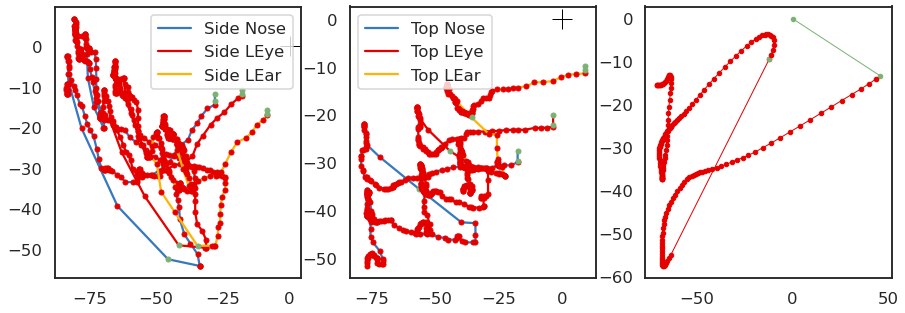

In [71]:
MAP_list = []
# for iTrial, data in enumerate(data_list):
iTrial = 7
data = data_list[iTrial]
xhat_lem = q_lem.mean_continuous_states[iTrial]
zhat_lem = rslds.most_likely_states(xhat_lem, data)
MAP_list.append(zhat_lem)
#     # store rslds
#     rslds_lem = copy.deepcopy(rslds)


fig, axes = plt.subplots(1,3,figsize=(15,5))

#Plot traces
for ii,view in enumerate(['Side','Top']):
    ax = axes[ii]
    for jj,ptstr in enumerate(['Nose','LEye','LEar']):
        ax.plot(data[:,ii*6+jj*2],data[:,ii*6+jj*2+1],'-',color=usrplt.cc[jj],label='{} {}'.format(view,ptstr))
        for state in np.unique(zhat_lem):
            indy = np.where(zhat_lem == state)[0]
            #Plot traces
            ax.plot(data[indy,ii*6+jj*2],data[indy,ii*6+jj*2+1],'.',color=usrplt.cc[state],ms=10)
    ax.legend()
    ax.plot(0,0,'+k',ms=20)
    
plot_trajectory(zhat_lem, xhat_lem,axes[2])

In [ ]:
ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'-',color=usrplt.cc[-1],alpha=0.5)

for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    #Plot traces
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,2],data[indy,3],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,4],data[indy,5],'.',color=usrplt.cc[state],ms=10)

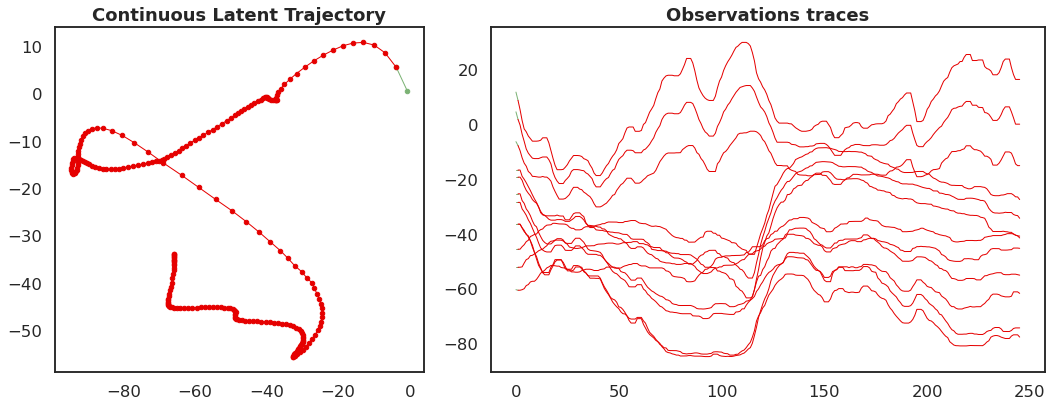

In [75]:
iTrial = 4
data = data_list[iTrial]
xhat_lem = q_lem.mean_continuous_states[iTrial]
zhat_lem = rslds.most_likely_states(xhat_lem, data)


fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(zhat_lem, xhat_lem, ax=ax0)
plt.title("Continuous Latent Trajectory")

ax1 = plt.subplot(gs[1])
plot_observations(zhat_lem, data, ax=ax1)
plt.title("Observations traces")
plt.tight_layout()

In [64]:
iTrial = 95
data = data_list[iTrial]
xhat_lem = q_lem.mean_continuous_states[iTrial]
zhat_lem = rslds.most_likely_states(xhat_lem, data)

lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]),nxpts=100, nypts=100,alpha=0.8, ax=None, figsize=(8, 8))

> <ipython-input-56-36a9a14aaef6>(67)plot_most_likely_dynamics()
     65     z = np.argmax(xy.dot(model.transitions.Rs.T))
     66     pdb.set_trace()
---> 67     if ax is None:
     68         fig = plt.figure(figsize=figsize)
     69         ax = fig.add_subplot(111)



ipdb>  z.shape


()


ipdb>  z


1


ipdb>  model.transitions.Rs.T


array([[ 0.00112068, -0.02387745,  0.00725271,  0.00455734,  0.01094672],
       [ 0.00010787, -0.00775663,  0.00334889,  0.0005463 ,  0.00375356]])


ipdb>  q


BdbQuit: 

In [55]:
np.argmax(xy.dot(rslds.transitions.Rs.T))

NameError: name 'xy' is not defined

In [52]:
abs(xhat_lem).max(axis=0) + 1

array([76.24518544, 45.6169693 ])

In [29]:
dir(rslds.transitions)

['D',
 'K',
 'M',
 'Rs',
 'Ws',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alpha',
 'initialize',
 'kappa',
 'l2_penalty',
 'log_Ps',
 'log_prior',
 'log_transition_matrices',
 'm_step',
 'neg_hessian_expected_log_trans_prob',
 'optimizer_state',
 'params',
 'permute',
 'transition_matrices',
 'transition_matrix']

In [ ]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(z, x, ax=ax0)
plt.title("True Trajectory")

ax1 = plt.subplot(gs[1])
plot_observations(z[:1000], y[:1000,:3], ax=ax1)
plt.title("Observations for first 1000 time steps")
plt.tight_layout()

In [180]:
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))

In [11]:
#Loop over trials and get the maximum a posteriori probability estimate of the latent states
MAP_list = []; posterior_list = []; mask_list = []

for data in data_list:
    expected_states, expected_joints, log_likes = arhmm.expected_states(data)

    MAP_list.append(np.argmax(expected_states,axis=1))
    posterior_list.append(expected_states)
    mask_list.append(np.max(expected_states,axis=1) > 0.8)


In [154]:
##===== Save state sequences =====##
fpath = './results/preparatory_behavior_K-{}_ARHMM.mat'.format(K)
sio.savemat(fpath,{'MAP_list': MAP_list, 'posterior_list': posterior_list,'mask_list': mask_list})

In [210]:
K = 10
tmp_data = sio.loadmat('./results/preparatory_behavior_K-{}_ARHMM.mat'.format(K))
MAP_list = tmp_data['MAP_list'][0]
posterior_list = tmp_data['posterior_list'][0]
mask_list = tmp_data['mask_list'][0]

4264

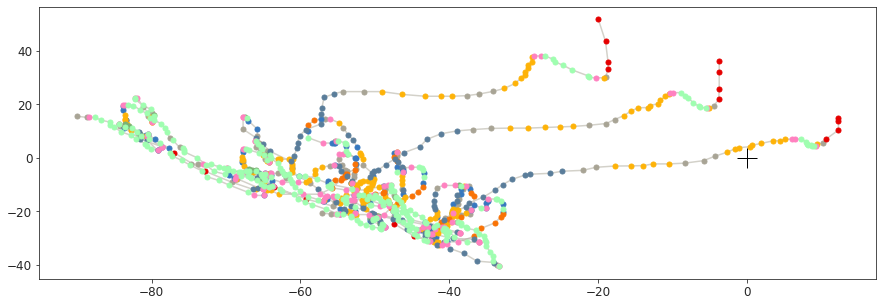

In [111]:
##===== Let's look at the states! =====##
iTrial = 550
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'-',color=usrplt.cc[-1],alpha=0.5)

for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    #Plot traces
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,2],data[indy,3],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,4],data[indy,5],'.',color=usrplt.cc[state],ms=10)

ax.plot(0,0,'+k',ms=20)


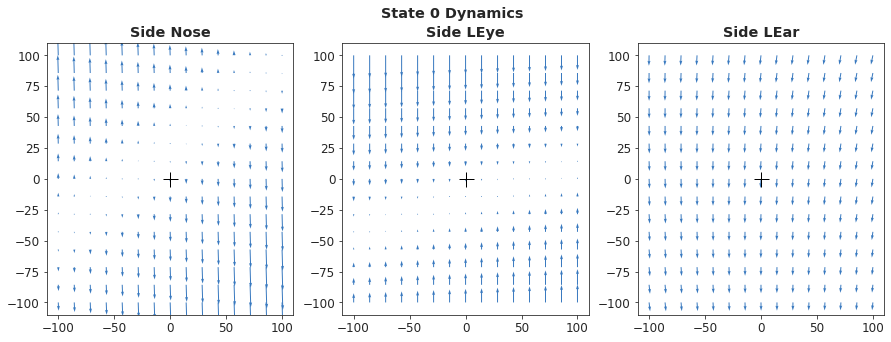

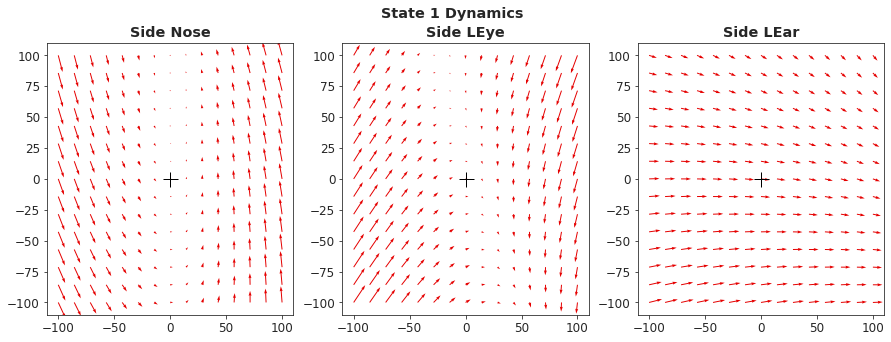

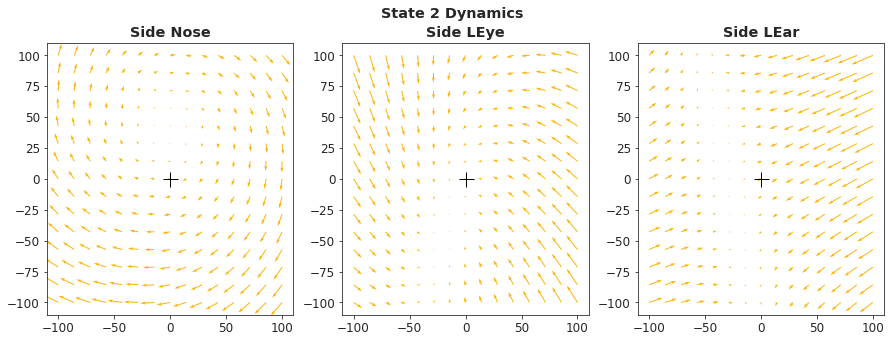

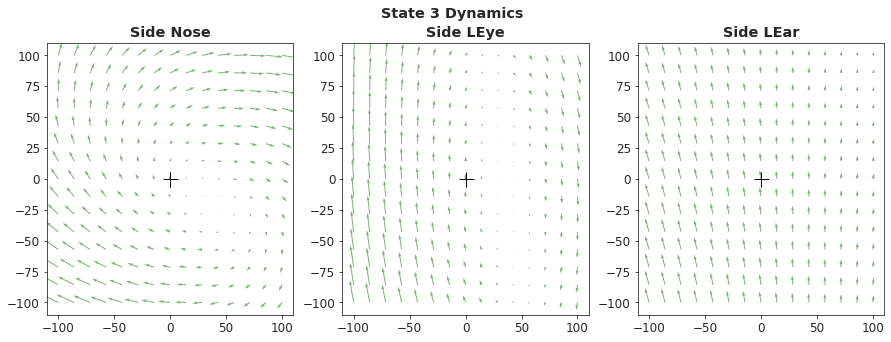

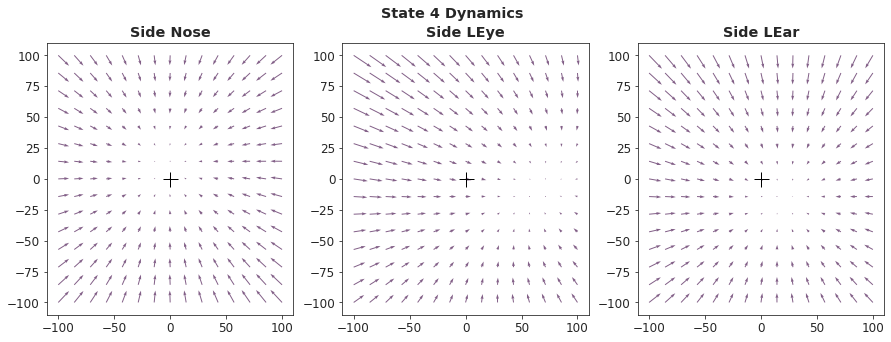

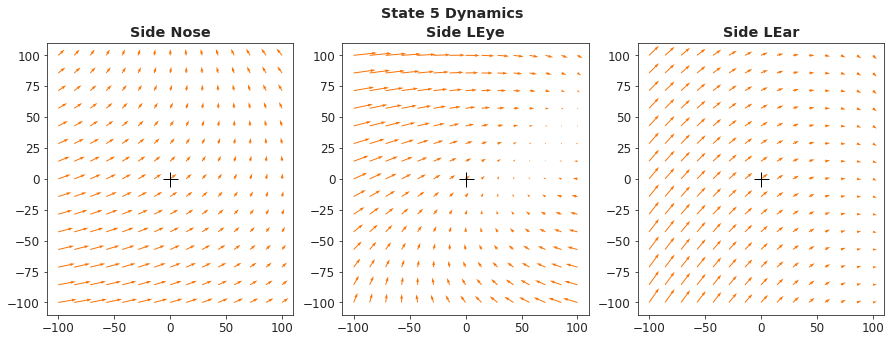

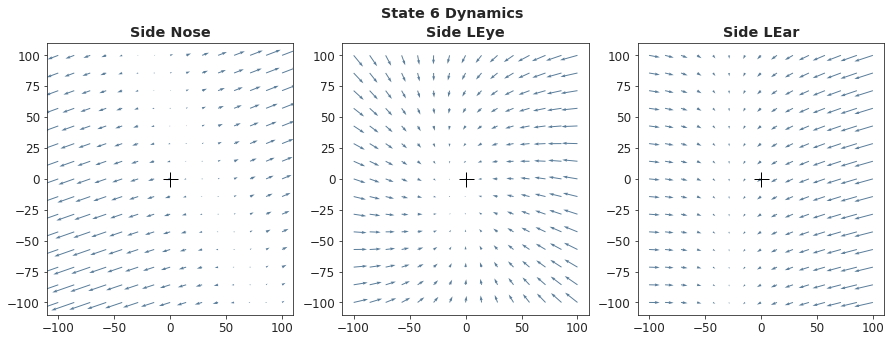

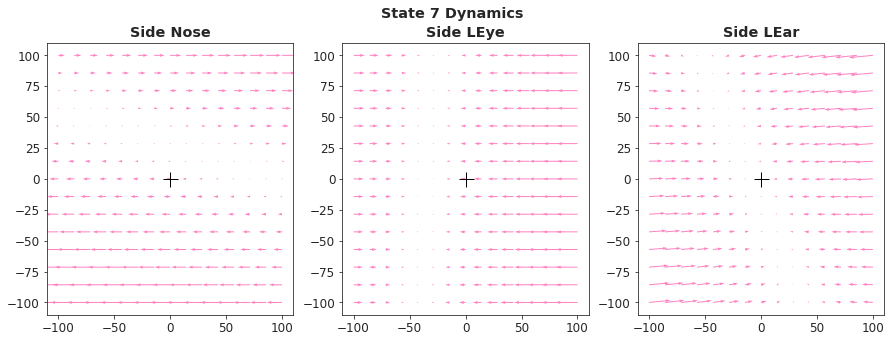

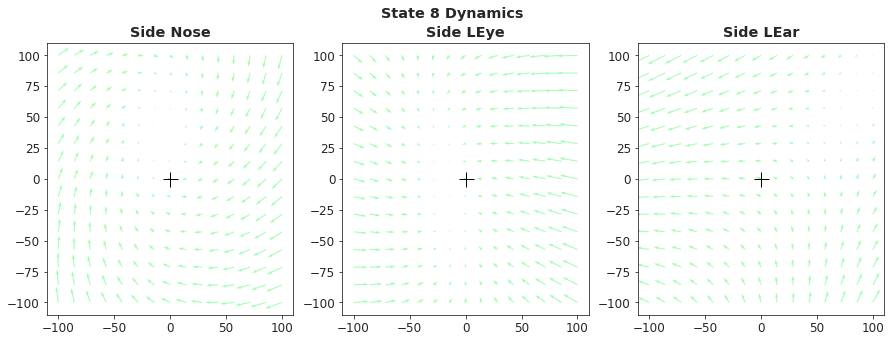

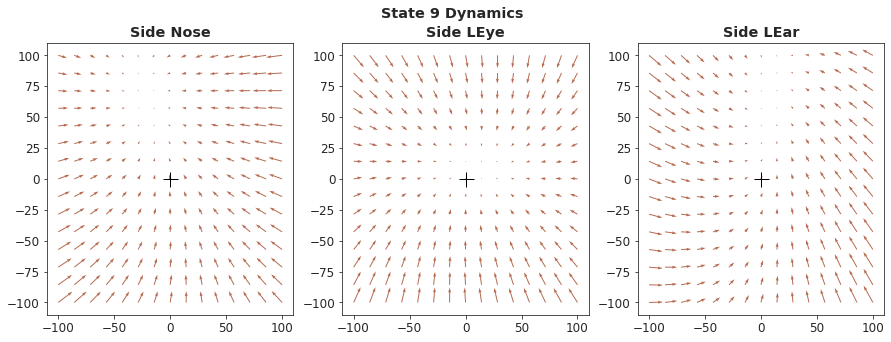

In [150]:
##===== Let's visualize the dynamics of each state  =====##
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('State {} Dynamics'.format(iState))

    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        AR = arhmm.observations.As[iState,slice(ii*2,(ii+1)*2),slice(ii*2,(ii+1)*2)]
        bias = arhmm.observations.bs[iState,slice(ii*2,(ii+1)*2)]
        usrplt.plot_dynamics_2d(AR,bias,mins=(-100,-100),maxs=(100,100),npts=15,axis=axes[ii],color=usrplt.cc[iState])
        axes[ii].set_title('Side {}'.format(ptstr))
        axes[ii].plot(0,0,'+k',ms=15)

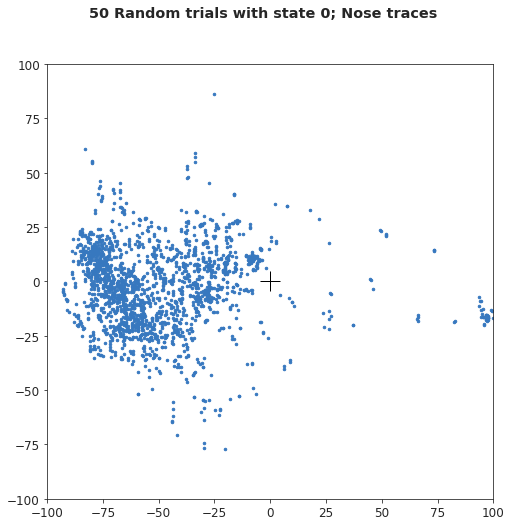

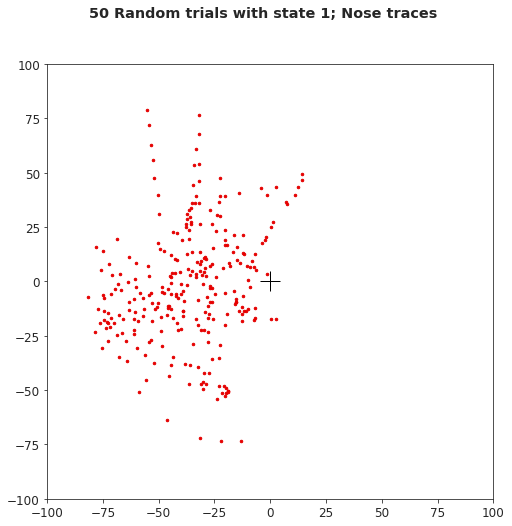

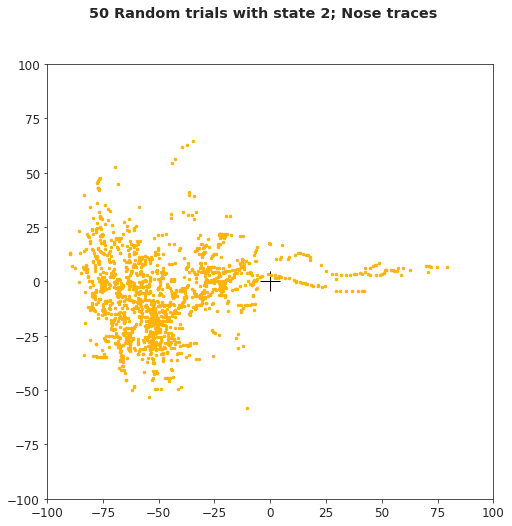

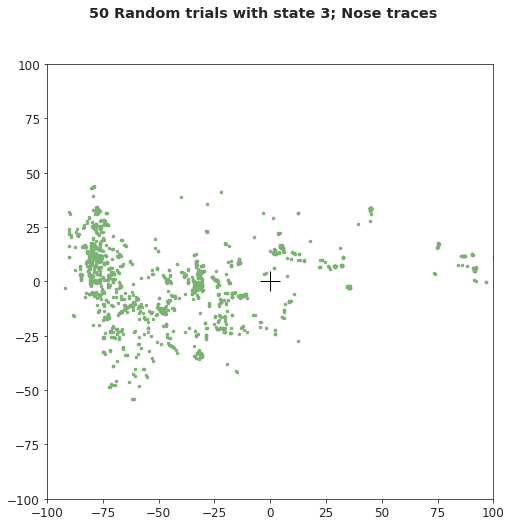

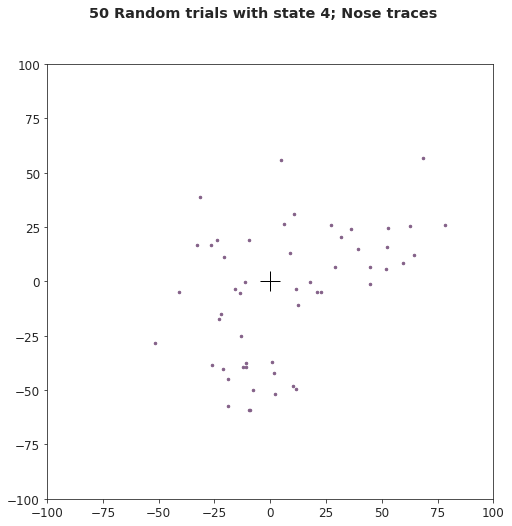

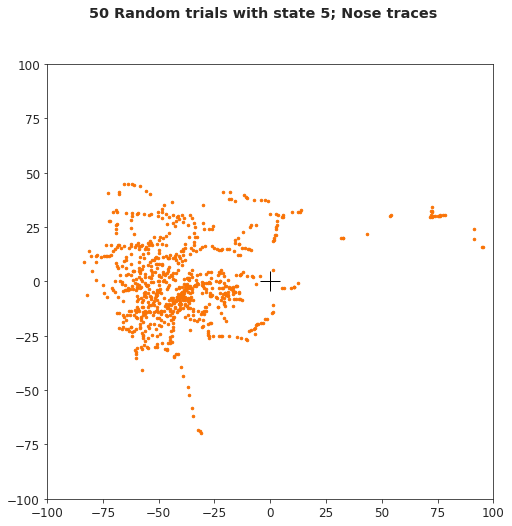

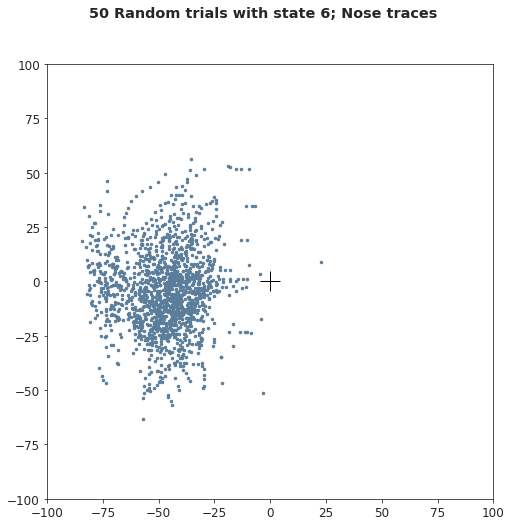

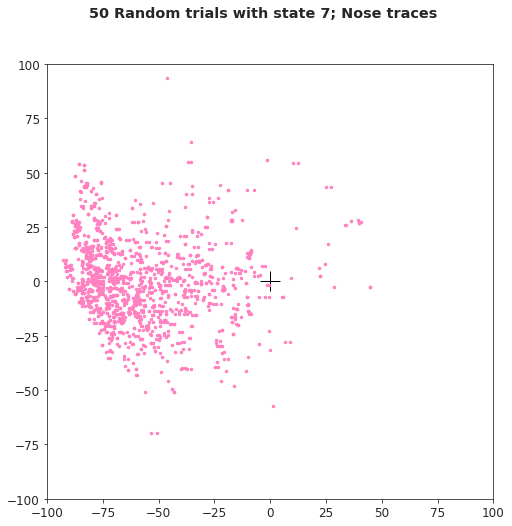

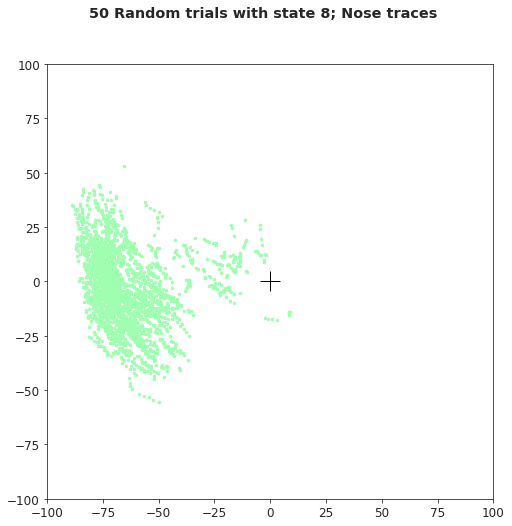

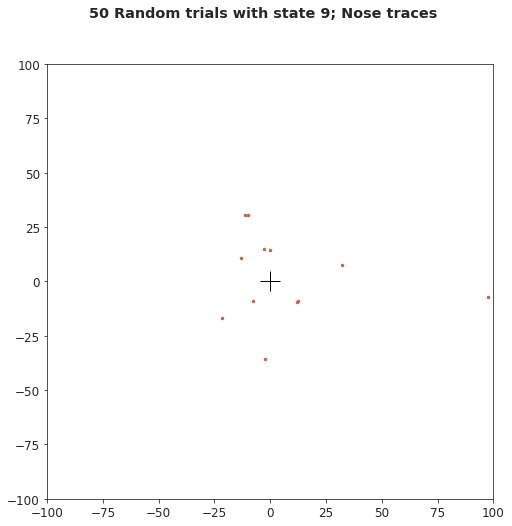

In [119]:


for state in range(K):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.suptitle('50 Random trials with state {}; Nose traces'.format(state))
    indy = np.random.randint(0, nTrials,50)
    
    ax.plot(0,0,'+k',ms=20)
    for iTrial in indy:
        mapseq = MAP_list[iTrial]
        data = data_list[iTrial]
        indy = np.where(mapseq == state)[0]
        #Plot nose traces
        ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=5)
    ax.set_xlim([-100,100])
    ax.set_ylim([-100,100])





In [12]:
#Calculate state duration and state usage 
state_duration_list, state_usage_list, state_usage = util.get_state_durations(MAP_list, mask_list, K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, 'NaN')]

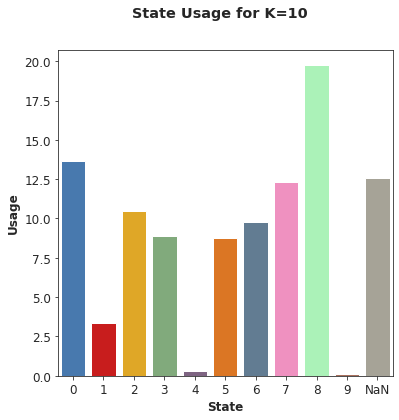

In [202]:
fig,ax = plt.subplots(figsize=(6,6))
plt.suptitle('State Usage for K={}'.format(K))

sns.barplot(np.arange(K+1),state_usage*100,palette=color_palette,ax=ax)
ax.set_xlabel('State')
ax.set_ylabel('Usage',fontsize=12)

tmp = [str(i) for i in np.arange(K)]
tmp.append('NaN')
ax.set_xticklabels(tmp)

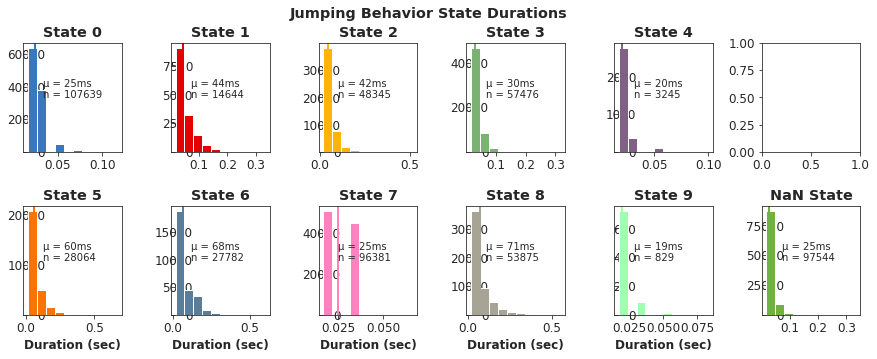

In [65]:
usrplt.plot_state_durations(state_duration_list, K)

<AxesSubplot:title={'center':'State Transition Matrix for ARHMM'}>

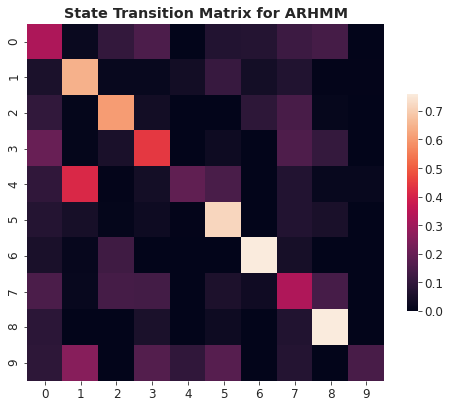

In [68]:
plt.figure(figsize = (8,8))
plt.title('State Transition Matrix for ARHMM')
transition_matrix = arhmm.transitions.transition_matrix
# transition_matrix[np.diag_indices(K)] = np.nan
sns.heatmap(transition_matrix,square=True,cbar_kws={'shrink':0.5})

In [157]:
MAP_list_sorted = sorted(MAP_list, key=len)[::-1]
mask_list_sorted = sorted(mask_list, key=len)[::-1]

In [176]:
len(MAP_list_sorted[1])

3809

In [191]:
max_trial_length = len(MAP_list_sorted[100])

#Let's look at the 500 longest state sequences together in a 
zs = np.zeros((200,max_trial_length)); zs[:] = np.nan

for iTrial in range(200):
    indy = np.where(mask_list_sorted[iTrial+100])
    mapseq = MAP_list_sorted[iTrial+100]
    nT = len(mapseq)
    zs[iTrial,indy] = mapseq[indy]
